# Práctica 3.2. Red Neuronal en TensorFlow

En esa práctica vamos a implementar una red neuronal muy sencilla en TensorFlow. Primero crearemos un conjunto de datos circular con SKLearn, y después crearemos la red capa por capa.

## 1. Creación del dataset

El siguiente código creará unos datos artificiales para entrenar nuestra red neuronal.

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

# Creamos nuestros datos artificiales, donde buscaremos clasificar 
# dos anillos concéntricos de datos. 
X, Y = make_circles(n_samples=500, factor=0.5, noise=0.05)

print(np.array(list(zip(X,Y)))[1:11], "...")

[[array([ 0.64574271, -0.81472137]) 0]
 [array([-1.01868687,  0.36954259]) 0]
 [array([-0.9259901 ,  0.39521667]) 0]
 [array([-0.12603277, -0.49698743]) 1]
 [array([0.57045543, 0.11891367]) 1]
 [array([-0.49037563, -0.30202275]) 1]
 [array([-0.47763282, -0.18548384]) 1]
 [array([-0.49546542,  0.86099632]) 0]
 [array([-1.06373624,  0.28575507]) 0]
 [array([-0.97097624, -0.49020488]) 0]] ...


Ya tenemos en X y en Y los datos. Pasemos a visualizarlos en un gráfico. Observar que tenemos 2 componentes (caracterísiticas, dimensiones) en la matrix X, y solo una dimensión en Y.

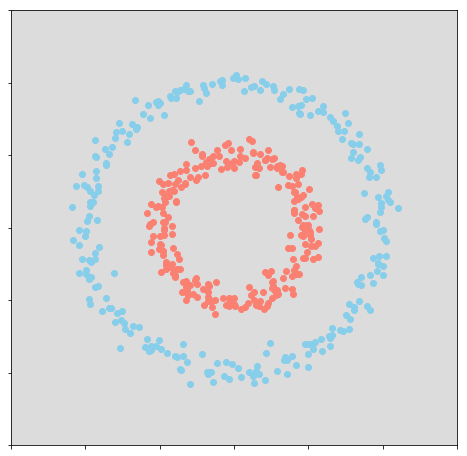

In [2]:
# Resolución del mapa de predicción.
res = 100 

# Coordendadas del mapa de predicción.
_x0 = np.linspace(-1.5, 1.5, res)
_x1 = np.linspace(-1.5, 1.5, res)

# Input con cada combo de coordenadas del mapa de predicción.
_pX = np.array(np.meshgrid(_x0, _x1)).T.reshape(-1, 2)

# Objeto vacio a 0.5 del mapa de predicción.
_pY = np.zeros((res, res)) + 0.5

# Visualización del mapa de predicción.
plt.figure(figsize=(8, 8))
plt.pcolormesh(_x0, _x1, _pY, cmap="coolwarm", vmin=0, vmax=1)

# Visualización de la nube de datos.
plt.scatter(X[Y == 0,0], X[Y == 0,1], c="skyblue")
plt.scatter(X[Y == 1,0], X[Y == 1,1], c="salmon")

plt.tick_params(labelbottom=False, labelleft=False)

## 2. Red neuronal en Tensorflow

A continuación crearemos la red neuronal en tensorflow (TF). Recordemos que tensorflow es una API de programación a nivel 1 para redes neuronales. Básicamente, TF provee una librería de diferenciación automática, es decir, calcularán los gradientes locales de manera automática para optimizar cualquier arquitectura que diseñemos. Esto se consigue mediante la representación de la arquitectura con un grafo de computación (tal y como vimos en el tema 2.3 sobre backpropagation).

Cada nodo del grafo puede representar una variable de entrada o una operación. Las conexiones entre los nodos son los tensores que fluyen a través del grafo. Esta estructura de grafo es ideal para calcular los gradientes y hacer diferenciación automática. Este grafo se declara explícitamente previamente a iniciar la sesión, como vimos en la práctica anterior.

Antes de comenzar, importemos las librerías necesarias.

In [3]:
# Importar TensorFlow
import tensorflow as tf

# Para crear la visualización animada del entrenamiento
from matplotlib import animation
from IPython.core.display import display, HTML

Primero definiremos las variables que serán nuestros placeholders. Uno para la matriz X, otro para el vector Y, que serán de tipo float y tendrán las dimensiones iguales que los datos de entrada. Recordemos que los **placeholders** son los puntos de entradas de datos al grafo computacional. 

In [4]:
# Definimos los puntos de entrada de la red, para la matriz X e Y.
iX = tf.placeholder('float', shape=[None, X.shape[1]])
iY = tf.placeholder('float', shape=[None])

Definimos el learning rate, y configuraremos la arquitectura de red mediante un vector, nn, que nos indicará cuantas neuronas habrá en cada capa. En este caso, tenemos 4 capas, la de entrada (con 2 nodos, porque X tiene dos dimensiones), la de salida (con una neurona, porque Y solo tiene una dimensión, es clasificación binaria), y dos capas ocultas con 16 y 8 neuronas cada una.

In [5]:
lr = 0.05           # learning rate
nn = [2, 16, 8, 1]  # número de neuronas por capa.

A continuación vamos a definir la red. Recordemos que una neurona artificial realiza una suma ponderada de sus entradas (según unos pesos), le suma un bias, y después pasa ese valor por una función de activación:

$$ f(b_i + \sum_{j=1}^{n_i} w_j x_j ) $$

Estas operaciones se pueden representar de manera matricial, por tanto, en vez de tener unidades sueltas, tendremos matrices que representarán los pesos de cada capa.

En TF, las **variables** serán los parámetros que serán optimizados en la red; en nuestro caso, los pesos W y los bias b. A continuación definimos la primera capa con tan solo:
* W1, que serán los pesos que conecten la capa de entrada con la primera oculta. Será un tensor 2D de 2x16. Se inicializan de forma aleatoria siguiendo una normal.
* b1, que será el bias para cada neurona en la primera capa oculta. Será un tensor 1D de 16 elementos. Se inicializan de forma aleatoria siguiendo una normal.
* l1, que serán las activaciones de la primera capa oculta: multiplicamos la entrada (placeholder) iX por los pesos W1, le sumamos b1, y la hacemos pasar por la función de activación ReLU.

In [6]:
# Capa 1
W1 = tf.Variable(tf.random_normal([nn[0], nn[1]]), name='Weights_1')
b1 = tf.Variable(tf.random_normal([nn[1]]), name='bias_1')

l1 = tf.nn.relu(tf.add(tf.matmul(iX, W1), b1))

Instructions for updating:
Colocations handled automatically by placer.


Podemos repetir el proceso para crear la segunda capa. En este caso W2 será un tensor 2D con los elementos necesarios para conectar la primera con la segunda capa, b2 será un tensor 1D con los bias, y l2 serán las activaciones. Esta vez, hay que multiplicar las activaciones de la capa anterior (en l1) por los pesos W2.

In [7]:
# Capa 2
W2 = tf.Variable(tf.random_normal([nn[1], nn[2]]), name='Weights_2')
b2 = tf.Variable(tf.random_normal([nn[2]]), name='bias_2')

l2 = tf.nn.relu(tf.add(tf.matmul(l1, W2), b2))

Repetimos con la capa 3. Esta capa es la de salida y tiene tan solo un nodo para predecir Y. Usaremos la función activación sigmoide, al tratarse de clasificación binaria, devolviendo tan solo un valor real entre 0 y 1.

In [8]:
# Capa 3
W3 = tf.Variable(tf.random_normal([nn[2], nn[3]]), name='Weights_3')
b3 = tf.Variable(tf.random_normal([nn[3]]), name='bias_3')

# Vector de predicciones de Y.
pY = tf.nn.sigmoid(tf.add(tf.matmul(l2, W3), b3))[:, 0]

Acabamos de definir el grafo computacional. Ahora pasemos a evaluarlo. Para ello, 

* definamos la función de pérdida, que será el MSE (error cuadrático medio) entre las predicciones Y y la entrada real Y.
* indicamos el optimizador que queremos utilizar para minimizar el error. En el ejemplo, descenso por gradiente (esto corresponde al SGD). Le decimos que queremos minimizar los valores de la función de pérdida.
* número de épocas, o pases que le daremos al conjunto de entrenamiento.
* un vector donde guardaremos la evolución de la predicción en cada pase.

In [9]:
# Evaluación de las predicciones.
loss = tf.losses.mean_squared_error(pY, iY)

# Definimos al optimizador de la red, para que minimice el error.
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)

n_steps = 1000 # Número de ciclos de entrenamiento.

iPY = [] # Aquí guardaremos la evolución de las predicción, para la animación.

Instructions for updating:
Use tf.cast instead.


Finalmente, definimos la sesión y lanzamos a ejecutar la optimización sobre el grafo de computación que nos hemos definido. Primero inicializamos las variables, y después ejecutamos la sesión pasándole los datos de entrada. Cada 25 iteraciones recogeremos las métricas.

In [10]:
with tf.Session() as sess:
  
  # Inicializamos todos los parámetros de la red, las matrices W y b.
  sess.run(tf.global_variables_initializer())
    
  # Iteramos n pases de entrenamiento.
  for step in range(n_steps):
  
    # Evaluamos al optimizador, a la función de coste y al tensor de salida pY. 
    # La evaluación del optimizer producirá el entrenamiento de la red.
    _, _loss, _pY = sess.run([optimizer, loss, pY], feed_dict={ iX : X, iY : Y })
    
    # Cada 25 iteraciones, imprimimos métricas.
    if step % 25 == 0: 
      
      # Cálculo del accuracy.
      acc = np.mean(np.round(_pY) == Y)
      
      # Impresión de métricas.
      print('Step', step, '/', n_steps, '- Loss = ', _loss, '- Acc =', acc)
      
      # Obtenemos predicciones para cada punto de nuestro mapa de predicción _pX.
      _pY = sess.run(pY, feed_dict={ iX : _pX }).reshape((res, res))

      # Y lo guardamos para visualizar la animación.
      iPY.append(_pY)

Step 0 / 1000 - Loss =  0.3713037 - Acc = 0.55
Step 25 / 1000 - Loss =  0.3255166 - Acc = 0.596
Step 50 / 1000 - Loss =  0.29643562 - Acc = 0.656
Step 75 / 1000 - Loss =  0.28172588 - Acc = 0.672
Step 100 / 1000 - Loss =  0.27083597 - Acc = 0.692
Step 125 / 1000 - Loss =  0.26171678 - Acc = 0.702
Step 150 / 1000 - Loss =  0.25375015 - Acc = 0.714
Step 175 / 1000 - Loss =  0.24553677 - Acc = 0.716
Step 200 / 1000 - Loss =  0.2357314 - Acc = 0.73
Step 225 / 1000 - Loss =  0.22433649 - Acc = 0.738
Step 250 / 1000 - Loss =  0.21050955 - Acc = 0.744
Step 275 / 1000 - Loss =  0.19673139 - Acc = 0.756
Step 300 / 1000 - Loss =  0.18269326 - Acc = 0.77
Step 325 / 1000 - Loss =  0.1699093 - Acc = 0.78
Step 350 / 1000 - Loss =  0.15885584 - Acc = 0.784
Step 375 / 1000 - Loss =  0.14822043 - Acc = 0.796
Step 400 / 1000 - Loss =  0.13883047 - Acc = 0.806
Step 425 / 1000 - Loss =  0.13053398 - Acc = 0.816
Step 450 / 1000 - Loss =  0.12277223 - Acc = 0.818
Step 475 / 1000 - Loss =  0.11537003 - Acc =

Por último, el siguiente código genera una animación de cómo ha evolucionado la red sobre los datos de entrada. Requiere tener instalado ffmpeg en el equipo.

--- Generando animación ---


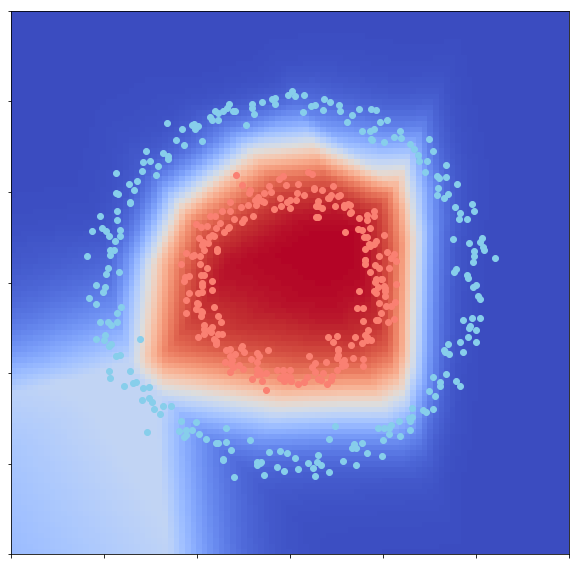

In [11]:
# ----- CÓDIGO ANIMACIÓN ----- #

ims = []

fig = plt.figure(figsize=(10, 10))

print("--- Generando animación ---")

for fr in range(len(iPY)):
  
  im = plt.pcolormesh(_x0, _x1, iPY[fr], cmap="coolwarm", animated=True)

  # Visualización de la nube de datos.
  plt.scatter(X[Y == 0,0], X[Y == 0,1], c="skyblue")
  plt.scatter(X[Y == 1,0], X[Y == 1,1], c="salmon")

  # plt.title("Resultado Clasificación")
  plt.tick_params(labelbottom=False, labelleft=False)

  ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

HTML(ani.to_html5_video())

## 3. Ejercicio

Modifica la red con el mínimo número de nodos y capas ocultas para que la red sea capaz de aprender a clasificar los datos de entrada.

## 4. Recomendación

Se recomienda ver la fuente de esta práctica al completo en este vídeo: https://www.youtube.com/watch?v=qTNUbPkR2ao. La implementación se compara contra Keras y SKLearn.